In [1]:
import itertools
import pandas as pd
import numpy as np
from functools import lru_cache
from typing import List, Tuple

In [2]:
def combined_cost_and_transport(path, flight_df, train_df, max_flights, max_trains):
    total_cost = 0
    transport = []
    flight_count = 0
    train_count = 0
    for i in range(len(path) - 1):
        flight_cost = flight_df.loc[path[i], path[i + 1]]
        train_cost = train_df.loc[path[i], path[i + 1]]
        if flight_count < max_flights and (train_count >= max_trains or flight_cost < train_cost):
            total_cost += flight_cost
            transport.append("Airplane")
            flight_count += 1
        elif train_count < max_trains:
            total_cost += train_cost
            transport.append("Train")
            train_count += 1
        else:
            return float('inf'), transport
    return total_cost, transport


def tsp_bruteforce_combined(flight_df, train_df, start_city, max_flights, max_trains):
    cities = flight_df.columns.tolist()
    cities.remove(start_city)
    min_cost = float('inf')
    min_path = None
    min_transport = None

    for path in itertools.permutations(cities):
        path = (start_city,) + path + (start_city,)
        cost, transport = combined_cost_and_transport(path, flight_df, train_df, max_flights, max_trains)
        if cost < min_cost:
            min_cost = cost
            min_path = path
            min_transport = transport

    return min_path, min_cost, min_transport


In [3]:
num = 10
all_cities = ['London', 'Paries', 'Berlin', 'Madrid', 'Rome', 'Vienna', 'Bucharest', 'Warsaw', 'Budapest', 'Hamburg']
cities = np.random.choice(all_cities, num, replace=False)

np.random.seed(42)
flight_costs = np.random.randint(500, 600, size=(num, num))
np.fill_diagonal(flight_costs, 0)
train_costs = np.random.randint(500, 700, size=(num, num))
np.fill_diagonal(train_costs, 0)

flight_df = pd.DataFrame(flight_costs, columns=cities, index=cities)
train_df = pd.DataFrame(train_costs, columns=cities, index=cities)

start_city = cities[0]
max_flights = 10
max_trains = 10


In [4]:
optimal_path, min_cost, optimal_transport = tsp_bruteforce_combined(flight_df, train_df, start_city, max_flights,
                                                                    max_trains)
print(f"shortest path: {optimal_path}")
print(f"way or transport: {optimal_transport}")
print(f"lowest fee: {min_cost}")


shortest path: ('Hamburg', 'Madrid', 'Paries', 'Rome', 'Vienna', 'Bucharest', 'Budapest', 'Berlin', 'Warsaw', 'London', 'Hamburg')
way or transport: ['Train', 'Airplane', 'Airplane', 'Train', 'Airplane', 'Airplane', 'Airplane', 'Airplane', 'Airplane', 'Train']
lowest fee: 5103


In [5]:
def held_karp_modified(flight_df, train_df, start_city, max_flights, max_trains):
    cities = flight_df.columns.tolist()
    cities.remove(start_city)
    cities_set = frozenset(cities)

    @lru_cache(maxsize=None)
    def dp(city, visited_cities, remaining_flights, remaining_trains):
        if visited_cities == cities_set:
            if remaining_flights > 0:
                return flight_df.loc[city, start_city], [start_city]
            else:
                return train_df.loc[city, start_city], [start_city]

        min_cost = float('inf')
        min_path = []

        for next_city in cities:
            if next_city not in visited_cities:
                new_visited_cities = visited_cities | {next_city}
                flight_cost = flight_df.loc[city, next_city]
                train_cost = train_df.loc[city, next_city]

                if remaining_flights > 0:
                    cost_flight, path_flight = dp(next_city, new_visited_cities, remaining_flights - 1, remaining_trains)
                    cost_flight += flight_cost

                    if cost_flight < min_cost:
                        min_cost = cost_flight
                        min_path = path_flight + [next_city]

                if remaining_trains > 0:
                    cost_train, path_train = dp(next_city, new_visited_cities, remaining_flights, remaining_trains - 1)
                    cost_train += train_cost

                    if cost_train < min_cost:
                        min_cost = cost_train
                        min_path = path_train + [next_city]

        return min_cost, min_path

    min_cost, optimal_path = dp(start_city, frozenset(), max_flights, max_trains)
    optimal_path = [start_city] + optimal_path[::-1]

    # Determine transport mode
    transport = []
    for i in range(len(optimal_path) - 1):
        if max_flights > 0 and (flight_df.loc[optimal_path[i], optimal_path[i+1]] <= train_df.loc[optimal_path[i], optimal_path[i+1]] or max_trains == 0):
            transport.append("Airplane")
            max_flights -= 1
        else:
            transport.append("Train")
            max_trains -= 1

    return optimal_path, min_cost, transport


In [6]:
optimal_path, min_cost, optimal_transport = held_karp_modified(flight_df, train_df, start_city, max_flights,
                                                                    max_trains)
print(f"shortest path: {optimal_path}")
print(f"way or transport: {optimal_transport}")
print(f"lowest fee: {min_cost}")


shortest path: ['Hamburg', 'Madrid', 'Paries', 'Budapest', 'Berlin', 'Warsaw', 'London', 'Bucharest', 'Rome', 'Vienna', 'Hamburg']
way or transport: ['Train', 'Airplane', 'Airplane', 'Airplane', 'Airplane', 'Airplane', 'Airplane', 'Airplane', 'Train', 'Airplane']
lowest fee: 5109


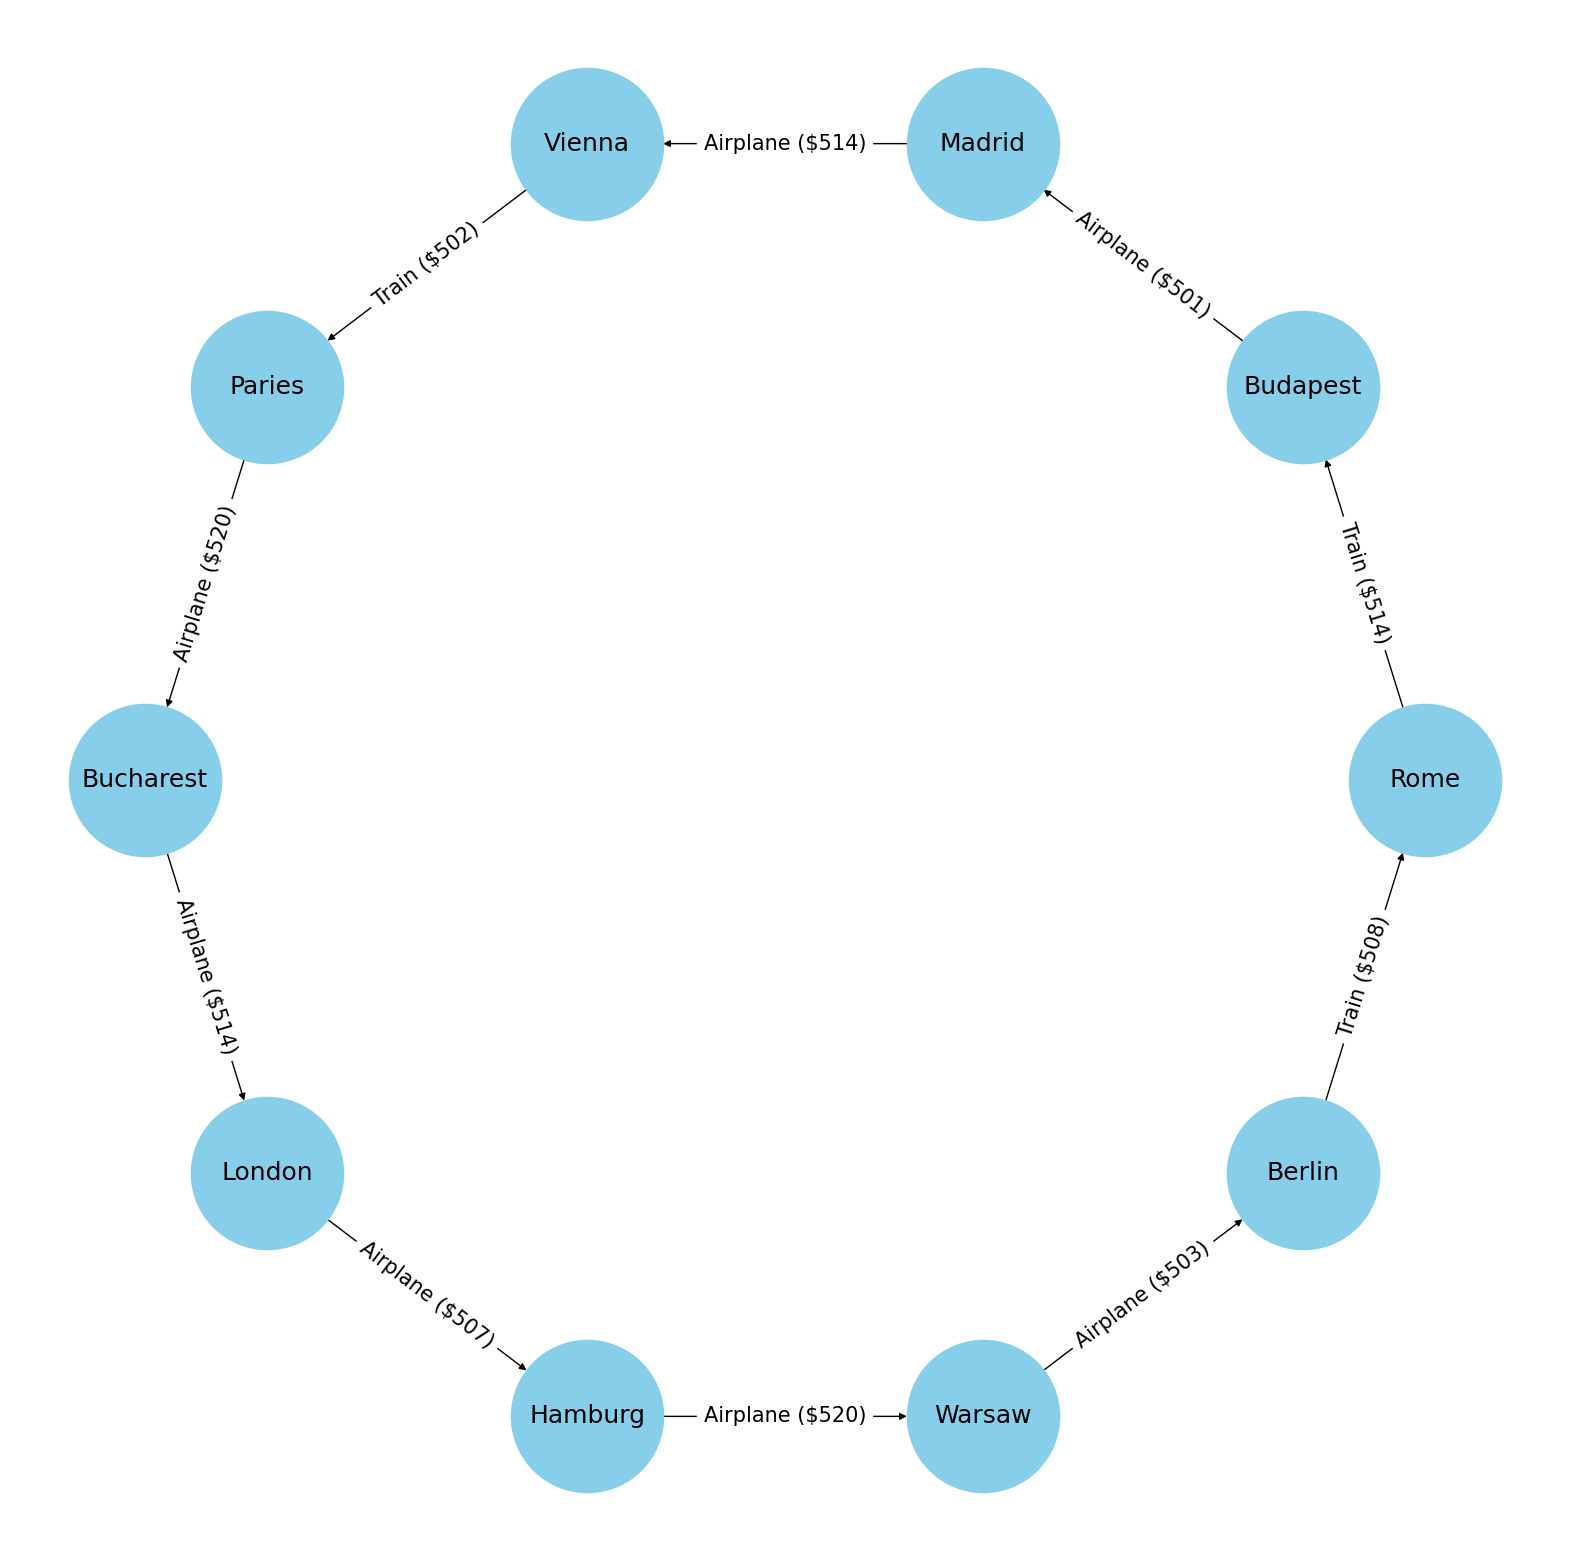

In [37]:
import matplotlib.pyplot as plt
import networkx as nx


def draw_graph(optimal_path, optimal_transport, flight_df, train_df):
    plt.rc('font', family='Menlo')
    G = nx.DiGraph()
    edge_labels = {}

    for i in range(len(optimal_path) - 1):
        G.add_edge(optimal_path[i], optimal_path[i + 1])
        transport = optimal_transport[i]
        cost = flight_df.loc[optimal_path[i], optimal_path[i + 1]] if transport == 'Airplane' else train_df.loc[
            optimal_path[i], optimal_path[i + 1]]
        edge_labels[(optimal_path[i], optimal_path[i + 1])] = f"{transport} (${cost})"

    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(20, 20))  # 调整画布大小
    nx.draw(G, pos, with_labels=True, node_size=12000, node_color="skyblue", font_size=18, font_weight='regular',
            arrows=True, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, font_weight='regular', ax=ax)
    plt.axis('off')
    plt.show()


draw_graph(optimal_path, optimal_transport, flight_df, train_df)
